In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
# Replace with your dataset class
from torch.utils.data import DataLoader, random_split
import timm  # Import the timm library for RegNet models
import sklearn

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

data_dir = '/content/drive/MyDrive/Dataset'

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataset
# Create a dataset
# Create a dataloader
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = timm.create_model('regnety_040', pretrained=True)
in_features = model.head.fc.in_features
num_classes = len(dataset.classes)
model.head.fc = nn.Linear(in_features, num_classes)

# Initialize the RegNetBinary model
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define loss function, optimizer, and training loop (similar to previous examples)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
    # Print or log training loss for this epoch

# Save the trained model
torch.save(model.state_dict(), 'regnet_binary_model.pth')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/82.9M [00:00<?, ?B/s]

Epoch 1/1, Loss: 0.004362662322819233


Test Accuracy: 96.55%
Confusion Matrix:
[[23  2]
 [ 0 33]]
Precision: 0.97
F1 Score: 0.97


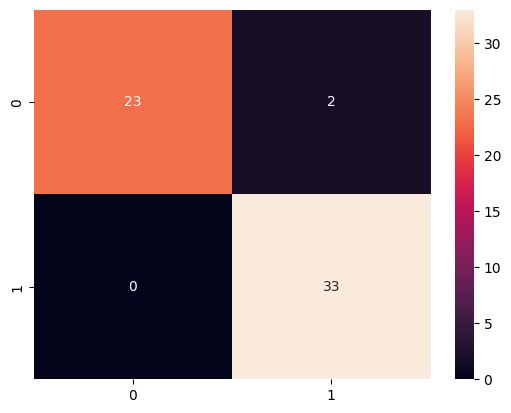

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score
# Set the model to evaluation mode
model.eval()

# Evaluate the model on the test set
correct = 0
total = 0
all_labels = []
all_predicted = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True)

precision = precision_score(all_labels, all_predicted, average='weighted')
print(f"Precision: {precision:.2f}")

f1 = f1_score(all_labels, all_predicted, average='weighted')
print(f"F1 Score: {f1:.2f}")

In [5]:
from torchsummary import summary
device = torch.device("cuda")
summary(model.to(device),(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              ReLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
       ConvNormAct-5         [-1, 32, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]           4,096
          Identity-7        [-1, 128, 112, 112]               0
              ReLU-8        [-1, 128, 112, 112]               0
    BatchNormAct2d-9        [-1, 128, 112, 112]             256
      ConvNormAct-10        [-1, 128, 112, 112]               0
           Conv2d-11          [-1, 128, 56, 56]          73,728
         Identity-12          [-1, 128, 56, 56]               0
             ReLU-13          [-1, 128, 56, 56]               0
   BatchNormAct2d-14          [-1, 128,

In [6]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm

# Define data transforms for image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the user-provided image
image_path = '/content/drive/MyDrive/Dataset/normal/13 - Copy (3).png'  # Replace with the path to the user's image
user_image = Image.open(image_path)

import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

user_image_tensor = transforms.ToTensor()(user_image)
user_image_tensor_3_channels = user_image_tensor[:3, :, :]
# Convert the tensor back to a PIL image
user_image_pil = transforms.ToPILImage()(user_image_tensor)

# Change the number of channels from 4 to 3
user_image_pil = user_image_pil.convert('RGB')
# Preprocess the image
user_image = transform(user_image_pil)
user_image = user_image.unsqueeze(0)  # Add a batch dimension
# Load the trained RegNetBinary model
model = timm.create_model('regnety_040', pretrained=True)
in_features = model.head.fc.in_features
num_classes = len(dataset.classes)
model.head.fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load('/content/regnet_binary_model.pth'))  # Load the trained model

# Set the model to evaluation mode
model.eval()

# Make predictions on the user's image
with torch.no_grad():
    outputs = model(user_image)
    probabilities = torch.softmax(outputs, dim=1)

# Get the predicted class
_, predicted_class = torch.max(outputs, 1)

# Define a list of class labels corresponding to your dataset
class_labels = ["Cancer","healthy"]  # Replace with your class labels

# Print the predicted class name
predicted_class_name = class_labels[predicted_class.item()]
print(f"Predicted class: {predicted_class_name}")


Predicted class: healthy


In [7]:
import random  # Import the timm library for RegNet models
import matplotlib.pyplot as plt

random_sample = random.choice(dataset)
random_image= random_sample[0]
normalized_image = random_image.numpy().transpose((1, 2, 0))
normalized_image = (normalized_image - normalized_image.min()) / (normalized_image.max() - normalized_image.min())


Predicted class: Cancer


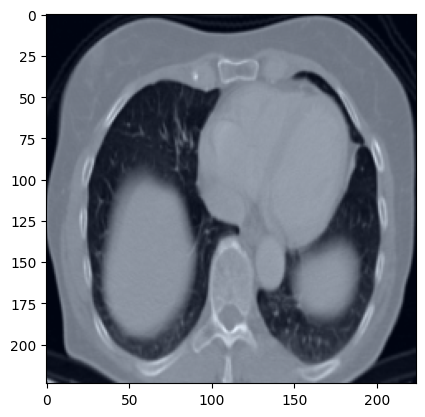

In [8]:
# from PIL import Image
# random_sample = random.choice(dataset)
# random_image= random_sample[0]
user_image = normalized_image

import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

user_image_tensor = transforms.ToTensor()(user_image)
user_image_tensor_3_channels = user_image_tensor[:3, :, :]
# Convert the tensor back to a PIL image
user_image_pil = transforms.ToPILImage()(user_image_tensor)

# Change the number of channels from 4 to 3
user_image_pil = user_image_pil.convert('RGB')
# Preprocess the image
user_image = transform(user_image_pil)
user_image = user_image.unsqueeze(0)  # Add a batch dimension
# Load the trained RegNetBinary model
model = timm.create_model('regnety_040', pretrained=True)
in_features = model.head.fc.in_features
num_classes = len(dataset.classes)
model.head.fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load('/content/regnet_binary_model.pth'))  # Load the trained model

# Set the model to evaluation mode
model.eval()

# Make predictions on the user's image
with torch.no_grad():
    outputs = model(user_image)
    probabilities = torch.softmax(outputs, dim=1)

# Get the predicted class
_, predicted_class = torch.max(outputs, 1)

# Define a list of class labels corresponding to your dataset
class_labels = ["Cancer","healthy"]  # Replace with your class labels

# Print the predicted class name
predicted_class_name = class_labels[predicted_class.item()]
print(f"Predicted class: {predicted_class_name}")
normalized_image = random_image.numpy().transpose((1, 2, 0))
normalized_image = (normalized_image - normalized_image.min()) / (normalized_image.max() - normalized_image.min())
# Display the image using matplotlib
plt.imshow(normalized_image)
plt.show()